# <center>Tarea 1 - Introducción a las Redes Neuronales Artificiales</center>
## <center> Ariel Sanhueza - 201173005-4 </center>
## <center> Diego Pérez - 201173xxx-y </center>

### Previo
Primero importaremos las bibliotecas necesarias para desarrollar la tarea.

In [67]:
%matplotlib inline
import numpy as np

from numpy.random import rand
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

## Problema 1

### a)
Primero generamos una función que genere $n$ pares (x,y), donde $x \in [-1,1]^2, y \in \{0,1\}$, como se sugirió en el enunciado.

In [68]:
def generate_data(n):
    # Generamos la matriz con los datos, de tamaño nx3
    ndata = 2*rand(n,3) - 1
    # Calculamos el valor que corresponde a y
    for i in range(n):
        if (ndata[i,0] > 0 and ndata[i,1] > 0) or (ndata[i,0] <= 0 and ndata[i,1] <= 0):
            ndata[i,2] = 0
        else:
            ndata[i,2] = 1
    return ndata

El problema se llama **XOR** pues la función de clasificación es la de la operación "OR-Exclusive". La separación sigue la misma lógica del XOR binario. Generamos los datos de entrenamiento y prueba para luego separarlos en la *data* de entrada y la data con los outputs deseados.

In [69]:
training_dt = generate_data(1000)
test_dt = generate_data(1000)

In [70]:
# Separamos la data en entrada y salida
X_training = training_dt[:,:2]
Y_training = training_dt[:,2]
X_test = test_dt[:,:2]
Y_test = test_dt[:,2]

### b)
Procedemos a generar el modelo de una sola neurona. Se implementarán dos modelos utilizando las funciones de activación: **lineal** y **sigmoidal**. Esto se hará para demostrar que independiente de los parámetros de la neurona, el problema no puede ser resuelto por ella. Los parámetros de la compilación son seteados de acuerdo a la página oficial de *keras* sobre un ejemplo de clasificador binario.

In [71]:
# Primero modelo
model = Sequential()
model.add(Dense(1, input_dim=2, activation='linear'))

In [72]:
# Compilamos
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
# Entrenamos
model.fit(X_training, Y_training, nb_epoch=50)

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 5.5388 - acc: 0.2730     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 5.4931 - acc: 0.2820     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 5.4051 - acc: 0.2920     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 5.3456 - acc: 0.3050     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 5.3218 - acc: 0.3100     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 5.2945 - acc: 0.3160     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 5.2610 - acc: 0.3190     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 5.1948 - acc: 0.3250     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 5.1802 - acc: 0.3300     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 5.0769 - acc: 0.3370     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 4

In [74]:
# Evaluamos el modelo
scores = model.evaluate(X_test, Y_test)
print("\nPrecisión: {0:.2f}".format(scores[1]))

  32/1000 [..............................] - ETA: 0s
Precisión: 0.63


In [77]:
# Segundo modelo
model = Sequential()
model.add(Dense(1, input_dim=2, activation='sigmoid'))

In [78]:
# Compilamos
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
# Entrenamos
model.fit(X_training, Y_training, nb_epoch=50)

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 0.7458 - acc: 0.5070     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 0.7428 - acc: 0.5200     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.7401 - acc: 0.5210     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.7374 - acc: 0.5230     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.7346 - acc: 0.5310     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.7321 - acc: 0.5310     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 0.7298 - acc: 0.5340     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 0.7274 - acc: 0.5380     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 0.7251 - acc: 0.5390     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 0.7231 - acc: 0.5460     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 0

In [80]:
# Evaluamos el modelo
scores = model.evaluate(X_test, Y_test)
print("\nPrecisión: {0:.2f}%".format(scores[1]*100))

  32/1000 [..............................] - ETA: 0s
Precisión: 66.30%


Como se puede ver en ambos modelos, la precisión de clasificación en el conjunto de prueba es de aproximadamente un 50~60%. Esto se debe a que una sola neurona solo puede aproximar funciones lineales y por lo tanto solo puede resolver problemas linealmente separables. Dado que el problema **XOR** no es linealmente separable, utilizando una sola recta se tiene en aproximadamente un 50% de precisión teórica.

### c)
Ahora veremos para un modelo de 3 capas, con 10 neuronas en la capa oculta. La activación de las capas ocultas será una función Tangente Hiperbólica. La capa de salida tendrá activación lineal.

In [41]:
# Creamos la red con sus parámetros
model = Sequential()
model.add(Dense(10, input_dim=2, activation='tanh'))
model.add(Dense(1, activation='linear'))

In [42]:
# Compilamos
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
# Entrenamos
model.fit(X_training, Y_training, nb_epoch=50)

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 1.2048 - acc: 0.3850     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 0.7234 - acc: 0.4550     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.7043 - acc: 0.5210     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.6975 - acc: 0.5060     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.6935 - acc: 0.5240     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.6913 - acc: 0.4830     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 0.6893 - acc: 0.5460     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 0.6879 - acc: 0.5090     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 0.6860 - acc: 0.5080     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 0.6845 - acc: 0.4910     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 0

In [44]:
# Evaluamos el modelo
scores = model.evaluate(X_test, Y_test)
print("\nPrecisión: {0:.2f}%".format(scores[1]*100))

  32/1000 [..............................] - ETA: 0s
Precisión: 91.20%


Como se puede ver en este experimento utilizando el modelo descrito la precisión en el set de prueba es de un 91.20% por lo que, dependiendo de los parámetros escogidos, el problema sí es resolvible mediante un perceptrón multicapas.

## Problema 2

### a)
Obtenemos los datos del link facilitado. Las líneas realizan (utilizando la enumeración del enunciado de la tarea):
* Línea 3: Se lee el CSV desde la URL entregada. Se marca el caracter ',' como separador de los datos y el parámetro *names* indica los nombres que tendrá cada columna.
* Línea 4: importa desde sklearn la función train_test_split que separa el dataset entre datos de entrenamiento y testing de forma aleatoria.
* Línea 5: Aplica train_test_split para separar en subconjuntos de entrenamiento y testeo utilizando un porcentaje fijo (25%) para la prueba.

In [45]:
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'

df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

### b)
El dataset contiene:
* El tipo de la variable *df* es DataFrame, un tipo de datos de la bilioteca *pandas*.
* 506 filas enumeradas desde el 0 hasta el 505.
* Memoria que utiliza el Dataset (tamaño).
* Una descripción de cada columna con:
    * El nombre de la columna.
    * La cantidad de datos en la columna.
    * Si hay datos nulos (datos faltantes).
    * El tipo de dato que contiene esa columna.

In [46]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(9), int64(5)
memory usage: 55.4 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.347826,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.083004,356.674032,12.653063,22.532806
std,8.601545,23.310593,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.280574,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.000000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.000000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.000000,391.440000,11.360000,21.200000
75%,3.677082,12.000000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.000000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### c)
Cuando los datos vienen en escalas muy diferentes puede llevar a que las características con valores numéricos más grandes logren mayor peso frente a los de menor valor (por ejemplo a la hora de calcular distancias). Normalizar los datos permite que todos los datos tengan un aporte "igualitario" a la hora de entrenar la red y de calcular los pesos.

In [47]:
# Datos de entrenamiento
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('MEDV')
# Datos de testing
scaler2 = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler2.transform(df_test),columns=df_test.columns)
y_test_scaled = X_test_scaled.pop('MEDV')

### d)

In [48]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))

sgd = SGD(lr=0.2)
model.compile(optimizer=sgd,loss='mean_squared_error')

hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 191992917638297639976960.0000 - val_loss: 402094062750811680761970688.0000
Epoch 2/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan                  
Epoch 3/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 4/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 5/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 6/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 7/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 8/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 9/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 10/300
379/379 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 11/300
379/379

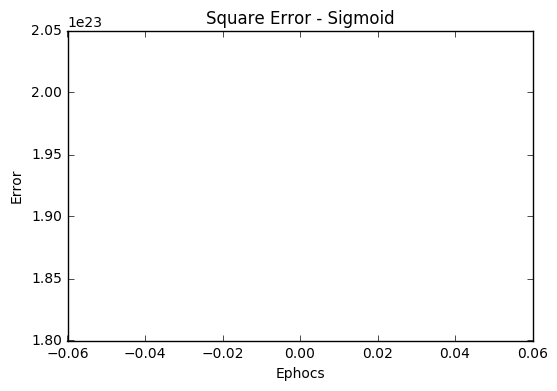

In [49]:
plt.plot(hist.history['loss'])
plt.title('Square Error - Sigmoid')
plt.xlabel('Ephocs')
plt.ylabel('Error')
plt.show()

Como se puede ver en el output generador, el método diverge con los parámetros entregados. El gráfico no muestra nada pues no se obtuvieron resultados.

### e)

In [15]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))

sgd = SGD(lr=0.2)
model.compile(optimizer=sgd,loss='mean_squared_error')

hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 0.4305 - val_loss: 0.3412
Epoch 2/300
379/379 [==============================] - 0s - loss: 0.2065 - val_loss: 0.3198
Epoch 3/300
379/379 [==============================] - 0s - loss: 0.1724 - val_loss: 0.3073
Epoch 4/300
379/379 [==============================] - 0s - loss: 0.1442 - val_loss: 0.3660
Epoch 5/300
379/379 [==============================] - 0s - loss: 0.1566 - val_loss: 0.2539
Epoch 6/300
379/379 [==============================] - 0s - loss: 0.1503 - val_loss: 0.4369
Epoch 7/300
379/379 [==============================] - 0s - loss: 0.1456 - val_loss: 0.2977
Epoch 8/300
379/379 [==============================] - 0s - loss: 0.1436 - val_loss: 0.2655
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.1709 - val_loss: 0.2327
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.1136 - val_loss: 0.4473
Epoch 11/300
379/379 [===========

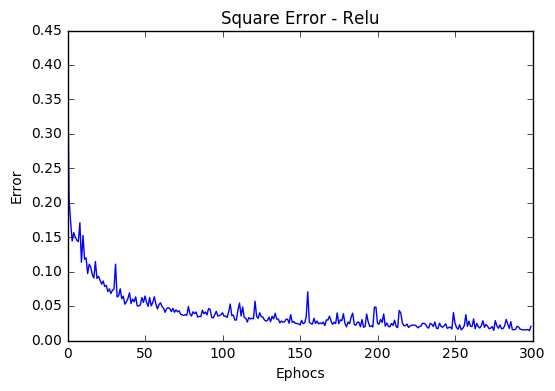

In [16]:
plt.plot(hist.history['loss'])
plt.title("Square Error - Relu")
plt.xlabel('Ephocs')
plt.ylabel('Error')
plt.show()

A diferencia del modelo anterior, utilizando la función *relu* el modelo sí converge. El gráfico muestra que a medida que aumenta el número de ephocs el error disminuye de manera asintótica quedando aproximadamente en 0.025.


### f)

In [51]:
# Generamos los n learning rates
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)

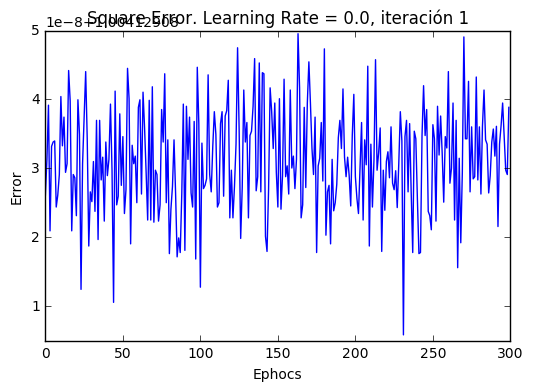

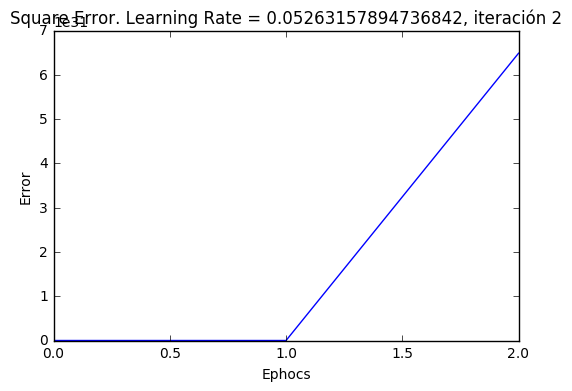

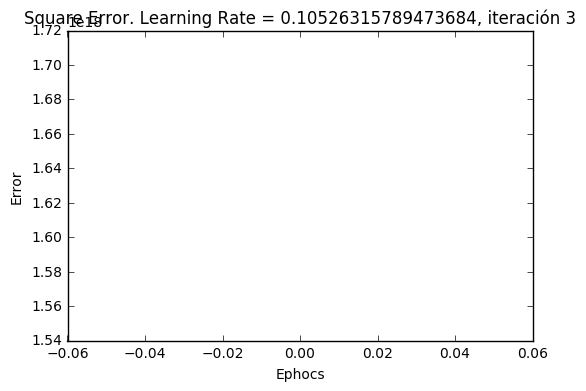

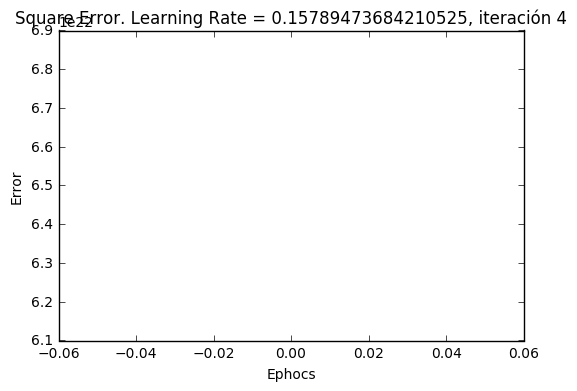

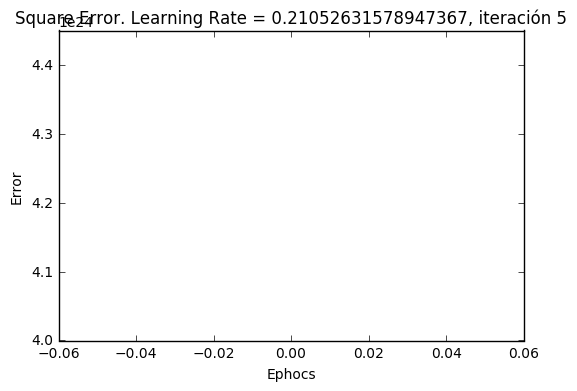

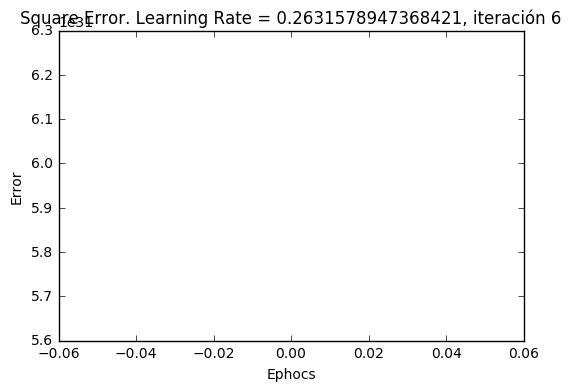

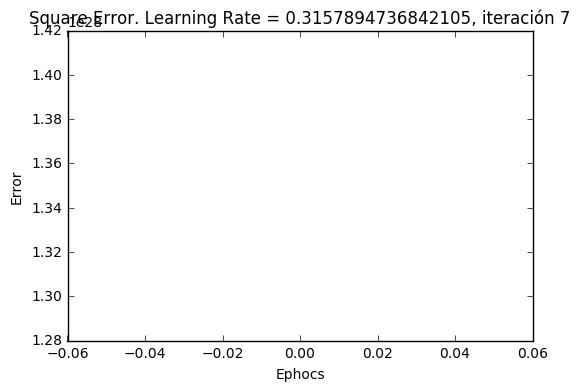

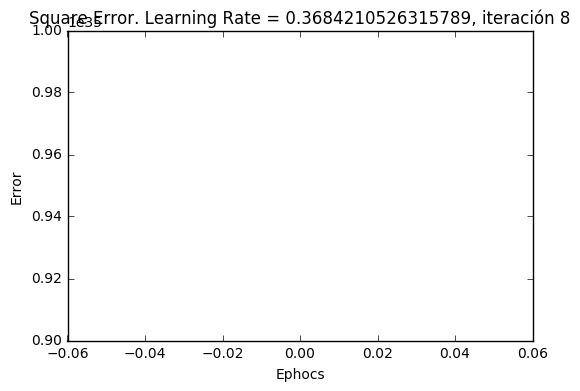

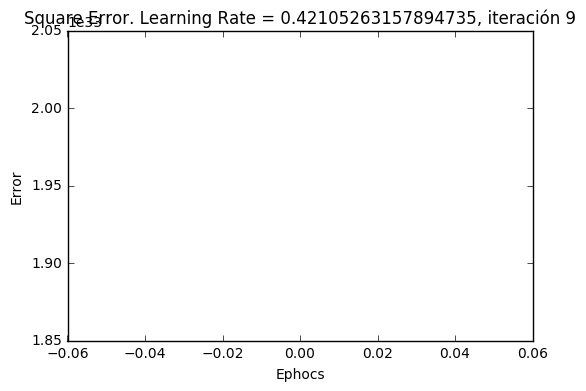

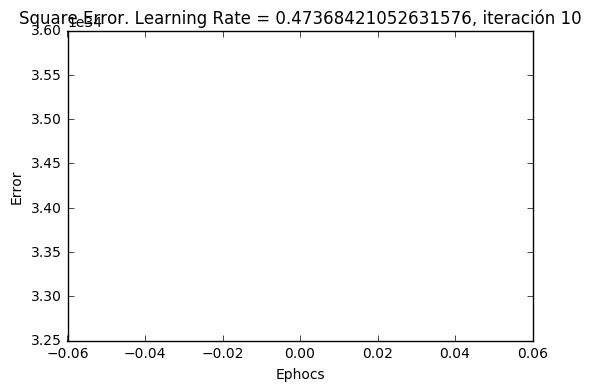

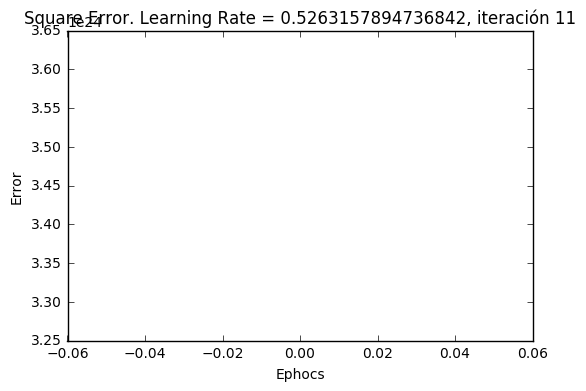

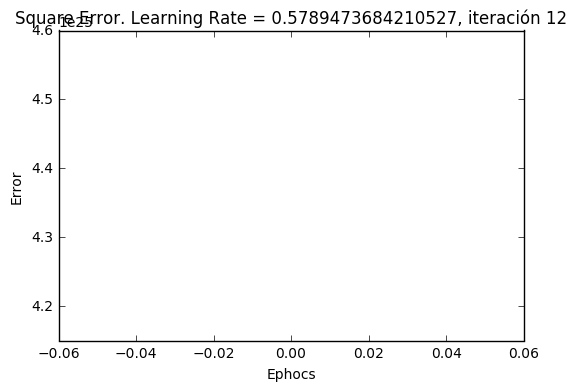

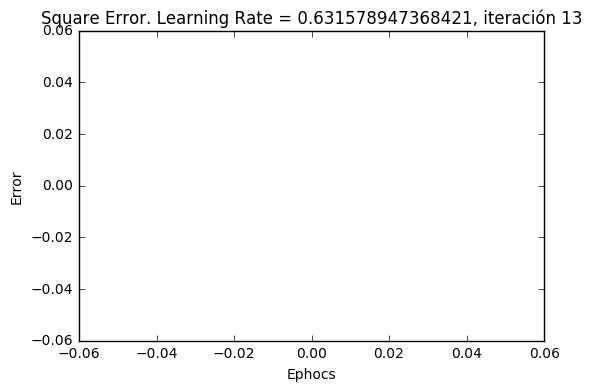

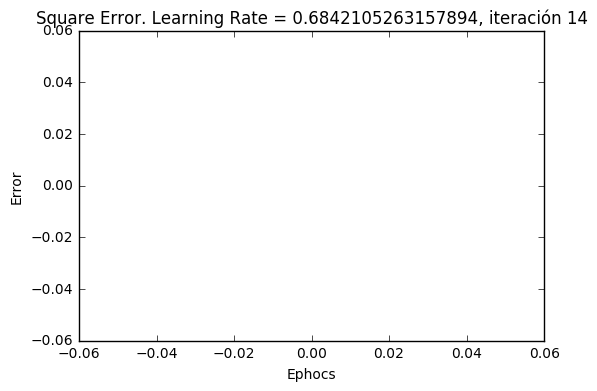

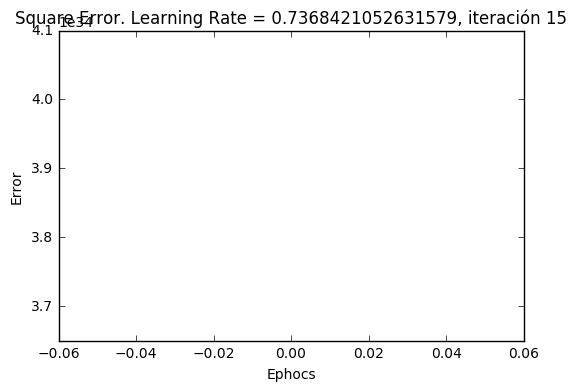

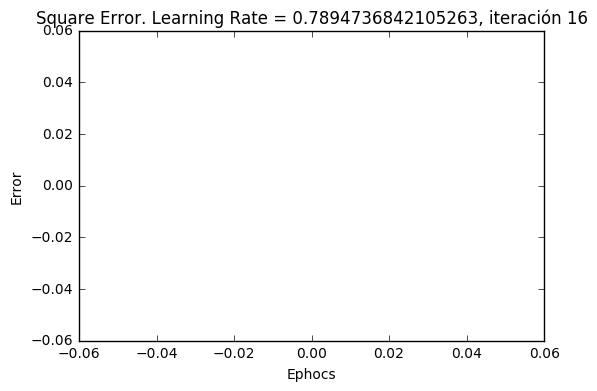

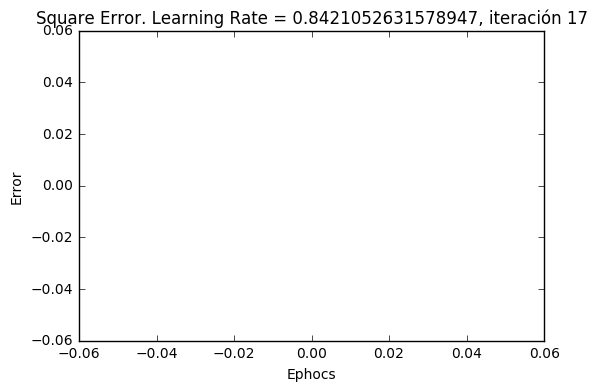

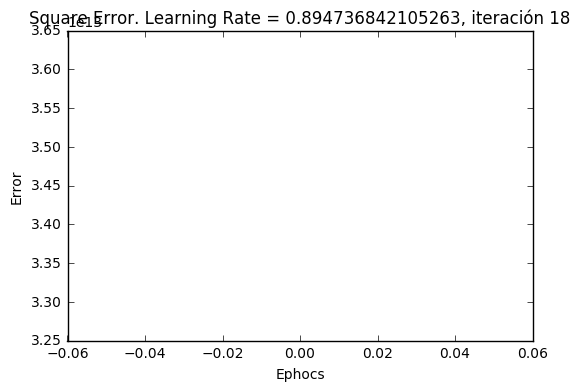

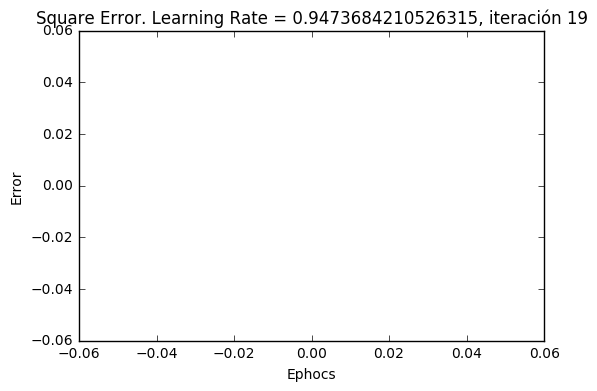

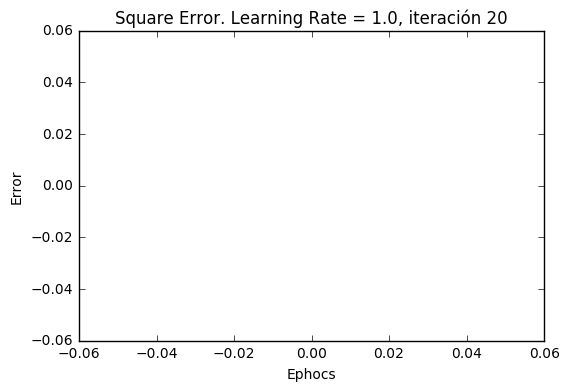

In [52]:
i = 1
for rate in lear_rate:
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=rate)
    model.compile(optimizer=sgd,loss='mean_squared_error')

    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    
    # Graficamos
    plt.plot(hist.history['loss'])
    plt.title("Square Error. Learning Rate = {0}, iteración {1}".format(rate, i))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()
    i += 1

Este método se probó en d) y no logró convergencia. Como se ve en el gráfico, los modelos generados variando el learning rate no convergen para ningún valor en el rango utilizado.

### g)

Primero probamos para la sigmoidal, con K = 5.

In [53]:
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = cross_validation.KFold(len(Xm), 5)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.2)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)

Epoch 1/300
303/303 [==============================] - 0s - loss: 68359616177028366336.0000
Epoch 2/300
303/303 [==============================] - 0s - loss: nan                               
Epoch 3/300
303/303 [==============================] - 0s - loss: nan     
Epoch 4/300
303/303 [==============================] - 0s - loss: nan     
Epoch 5/300
303/303 [==============================] - 0s - loss: nan     
Epoch 6/300
303/303 [==============================] - 0s - loss: nan     
Epoch 7/300
303/303 [==============================] - 0s - loss: nan     
Epoch 8/300
303/303 [==============================] - 0s - loss: nan     
Epoch 9/300
303/303 [==============================] - 0s - loss: nan     
Epoch 10/300
303/303 [==============================] - 0s - loss: nan     
Epoch 11/300
303/303 [==============================] - 0s - loss: nan     
Epoch 12/300
303/303 [==============================] - 0s - loss: nan     
Epoch 13/300
303/303 [==============================] 

In [54]:
print("Error total del modelo: {0}%".format(mse_cv*100))

Error total del modelo: nan%


Para K = 10, función sigmoidal.

In [46]:
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.2)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)

Epoch 1/300
341/341 [==============================] - 0s - loss: 104848881256532169271017472.0000
Epoch 2/300
341/341 [==============================] - 0s - loss: nan                                     
Epoch 3/300
341/341 [==============================] - 0s - loss: nan     
Epoch 4/300
341/341 [==============================] - 0s - loss: nan     
Epoch 5/300
341/341 [==============================] - 0s - loss: nan     
Epoch 6/300
341/341 [==============================] - 0s - loss: nan     
Epoch 7/300
341/341 [==============================] - 0s - loss: nan     
Epoch 8/300
341/341 [==============================] - 0s - loss: nan     
Epoch 9/300
341/341 [==============================] - 0s - loss: nan     
Epoch 10/300
341/341 [==============================] - 0s - loss: nan     
Epoch 11/300
341/341 [==============================] - 0s - loss: nan     
Epoch 12/300
341/341 [==============================] - 0s - loss: nan     
Epoch 13/300
341/341 [===================

In [47]:
print("Error total del modelo: {0}%".format(mse_cv*100))

Error total del modelo: nan%


Ahora utilizaremos la función Relu con K = 5.

In [55]:
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = cross_validation.KFold(len(Xm), 5)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.2)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)

Epoch 1/300
303/303 [==============================] - 0s - loss: 0.5642     
Epoch 2/300
303/303 [==============================] - 0s - loss: 0.2128     
Epoch 3/300
303/303 [==============================] - 0s - loss: 0.2042     
Epoch 4/300
303/303 [==============================] - 0s - loss: 0.2068     
Epoch 5/300
303/303 [==============================] - 0s - loss: 0.1857     
Epoch 6/300
303/303 [==============================] - 0s - loss: 0.1365     
Epoch 7/300
303/303 [==============================] - 0s - loss: 0.1595     
Epoch 8/300
303/303 [==============================] - 0s - loss: 0.1523     
Epoch 9/300
303/303 [==============================] - 0s - loss: 0.1393     
Epoch 10/300
303/303 [==============================] - 0s - loss: 0.1256     
Epoch 11/300
303/303 [==============================] - 0s - loss: 0.1391     
Epoch 12/300
303/303 [==============================] - 0s - loss: 0.1143     
Epoch 13/300
303/303 [==============================] - 0s - 

In [56]:
print("Error total del modelo: {0}%".format(mse_cv*100))

Error total del modelo: 13.506776839912984%


Finalmente probaremos con K = 10 utilizando la función Relu.

In [57]:
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.2)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)

Epoch 1/300
341/341 [==============================] - 0s - loss: 0.4482     
Epoch 2/300
341/341 [==============================] - 0s - loss: 0.1956     
Epoch 3/300
341/341 [==============================] - 0s - loss: 0.1824     
Epoch 4/300
341/341 [==============================] - 0s - loss: 0.1862     
Epoch 5/300
341/341 [==============================] - 0s - loss: 0.1772     
Epoch 6/300
341/341 [==============================] - 0s - loss: 0.1590     
Epoch 7/300
341/341 [==============================] - 0s - loss: 0.1477     
Epoch 8/300
341/341 [==============================] - 0s - loss: 0.1345     
Epoch 9/300
341/341 [==============================] - 0s - loss: 0.1246     
Epoch 10/300
341/341 [==============================] - 0s - loss: 0.1647     
Epoch 11/300
341/341 [==============================] - 0s - loss: 0.1115     
Epoch 12/300
341/341 [==============================] - 0s - loss: 0.1234     
Epoch 13/300
341/341 [==============================] - 0s - 

In [58]:
print("Error total del modelo: {0}%".format(mse_cv*100))

Error total del modelo: 12.525337985193469%


El modelo utilizando la función de activación sigmoidal no convergió en ninguno de los test utilizando *Cross Validation* por lo que el error que se obtuvo fue *NaN*. Por el contrario el modelo con la función *Relu* si logró convergencia y *Cross Validation* mostró un error un error en el modelo de aproximadamente 13%. Cabe destacar que los parámetros que se utilizaron en el modelo convergente fueron un learning rate de 0.2 y 300 epoch.

### h)

In [59]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)

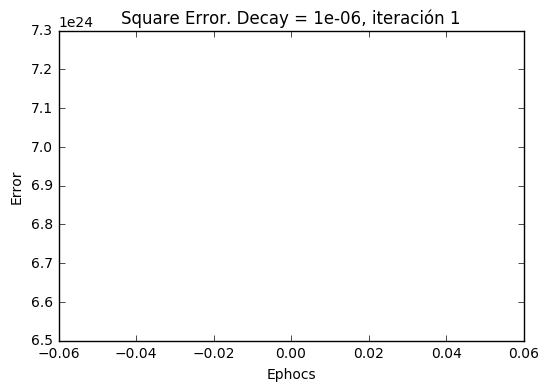

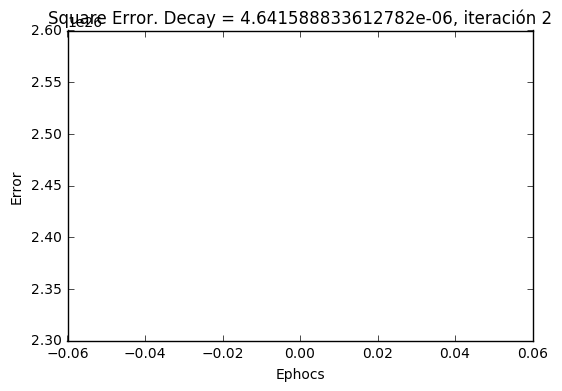

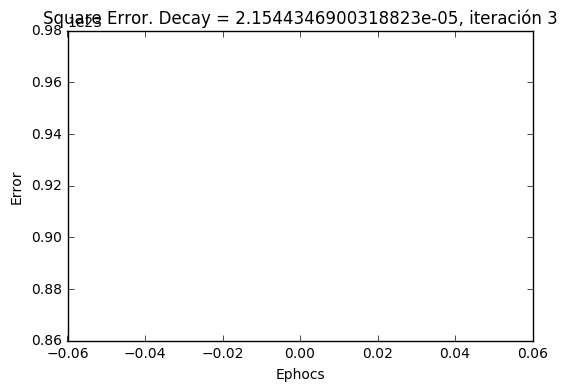

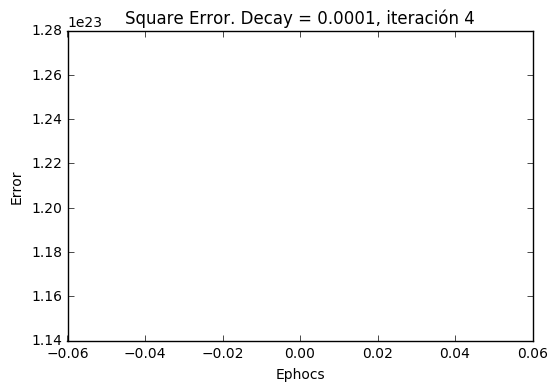

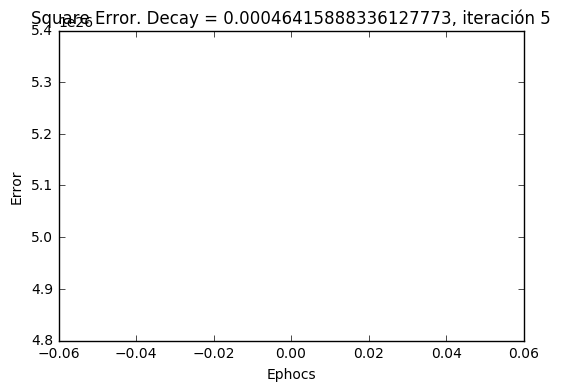

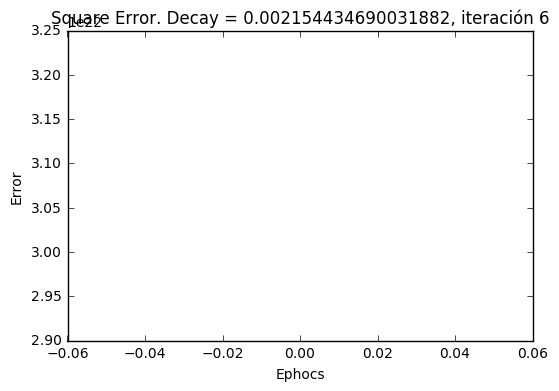

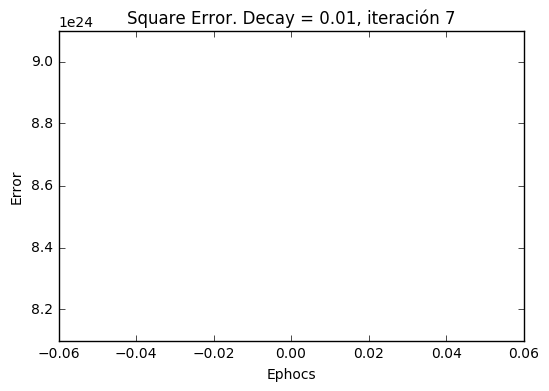

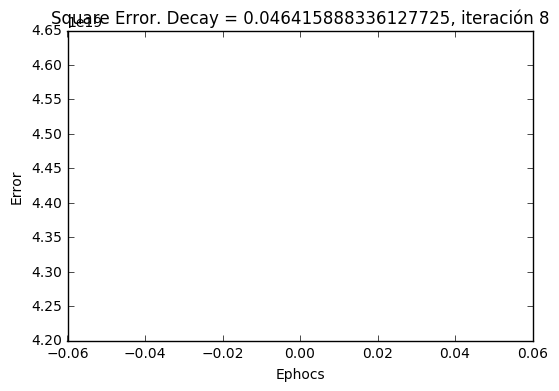

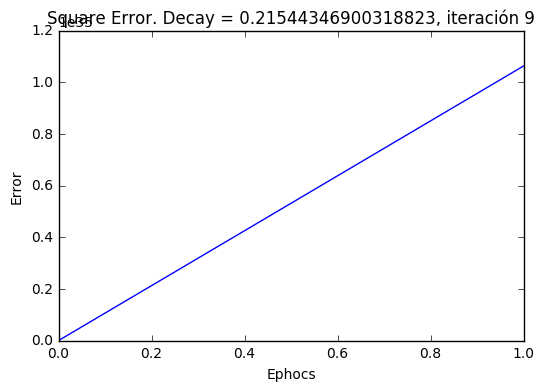

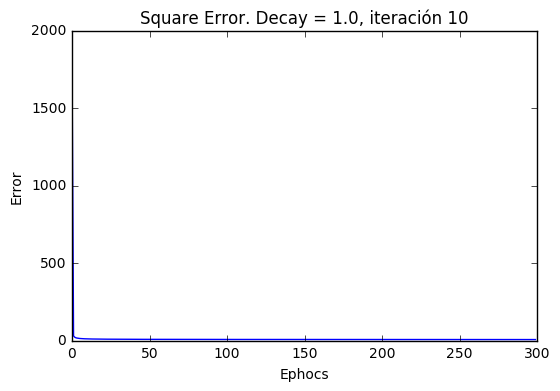

In [60]:
i = 1
for decay in lear_decay:
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=0.2, decay=decay)
    model.compile(optimizer=sgd,loss='mean_squared_error')

    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # Graficamos
    plt.plot(hist.history['loss'])
    plt.title("Square Error. Decay = {0}, iteración {1}".format(decay, i))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()
    i += 1

La modificación del *decay* no mejoró la convergencia del modelo. El método sigue divergiendo para la mayoría de los Decay. En los dos últimos casos se consiguen resultados y lograron que el método obtenga algún tipo de resultado pero con errores altos.

### i)

In [61]:
n_decay = 21
momentum = np.linspace(0,1,n_decay)

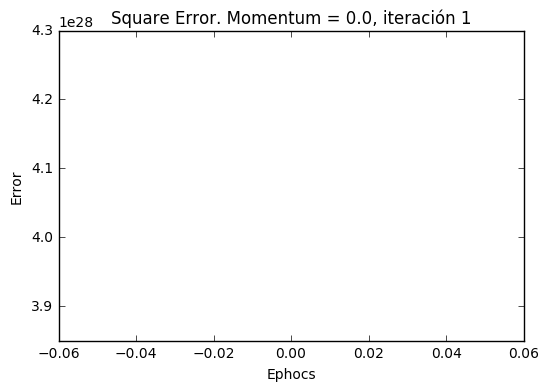

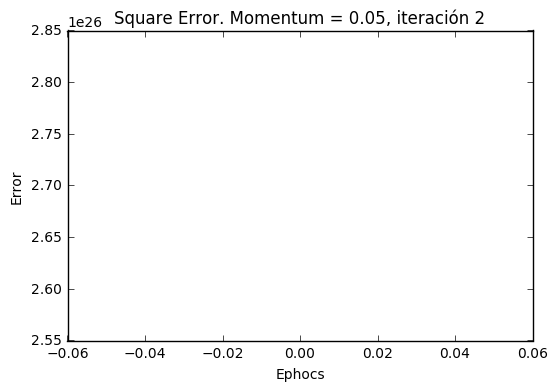

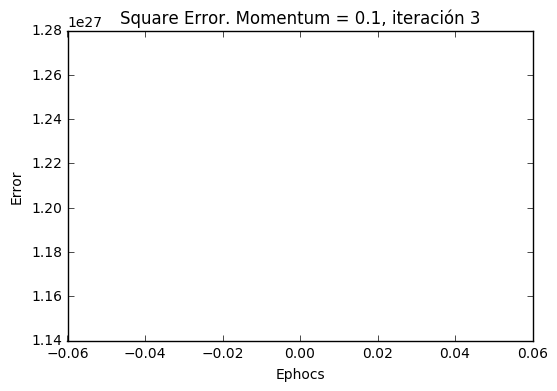

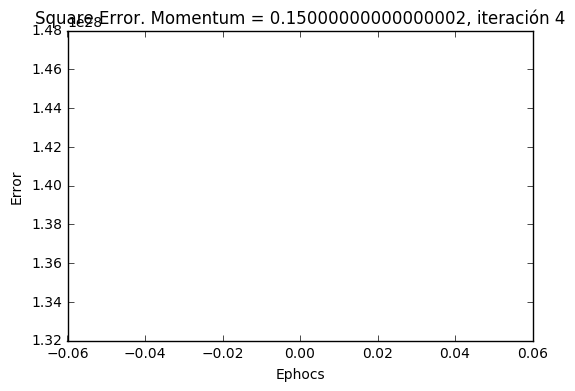

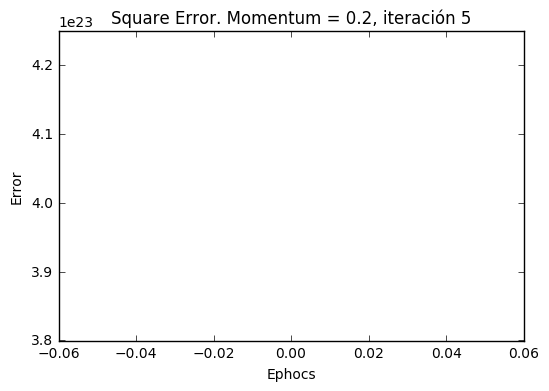

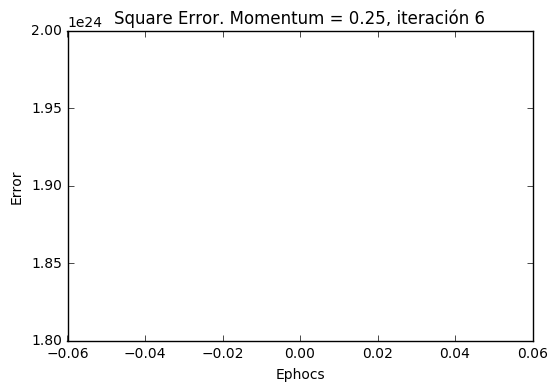

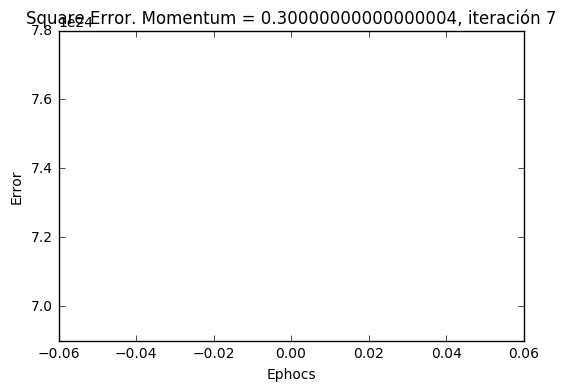

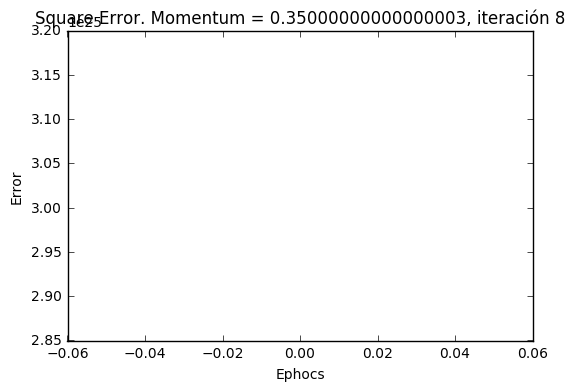

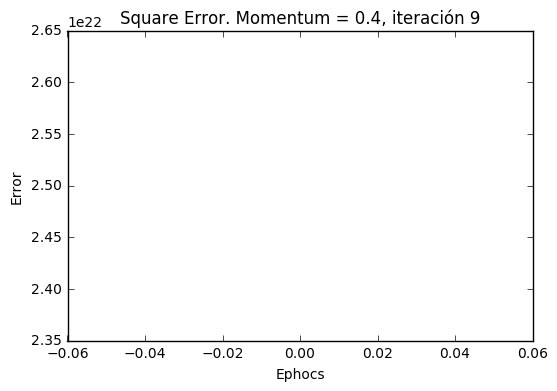

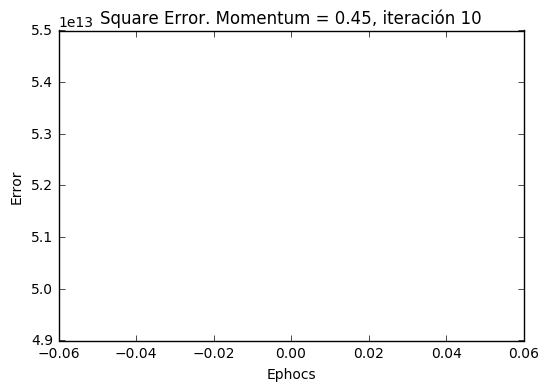

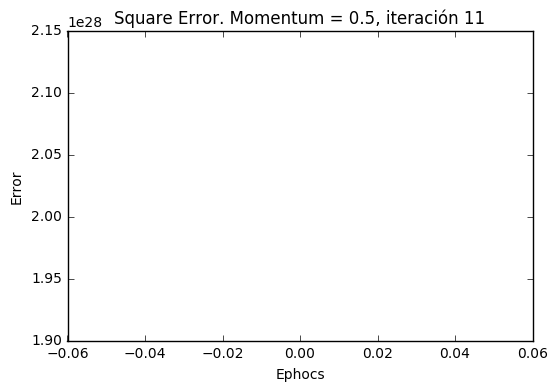

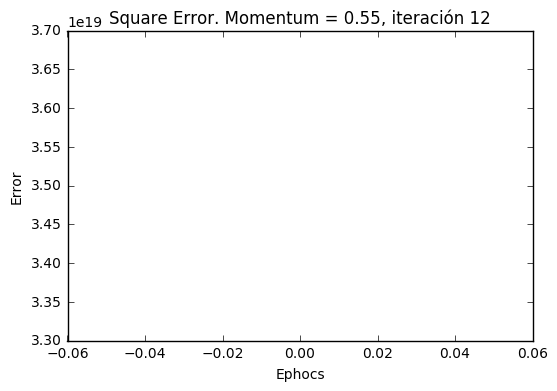

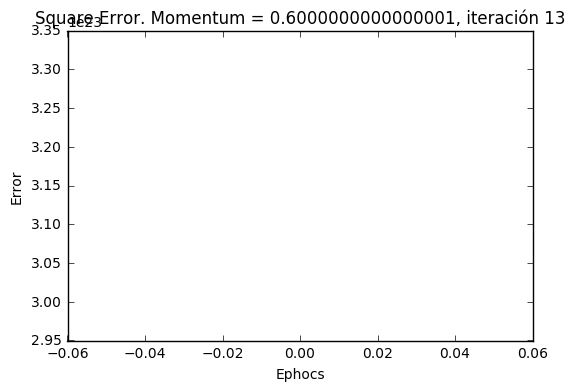

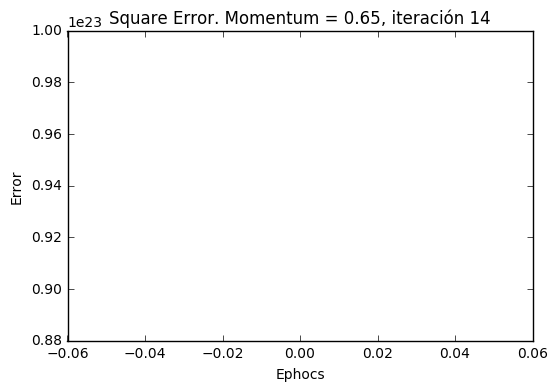

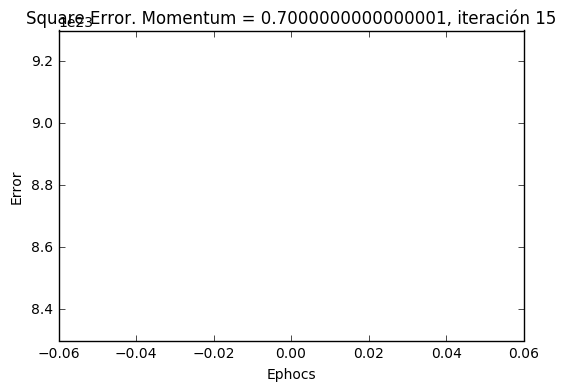

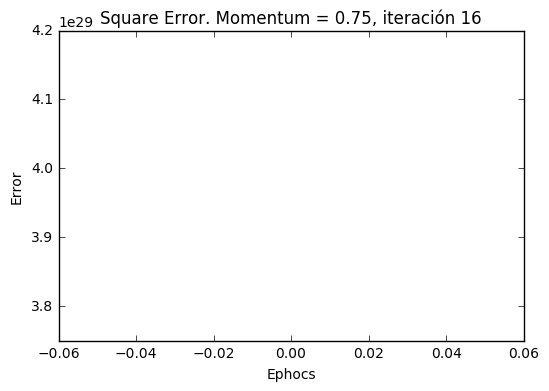

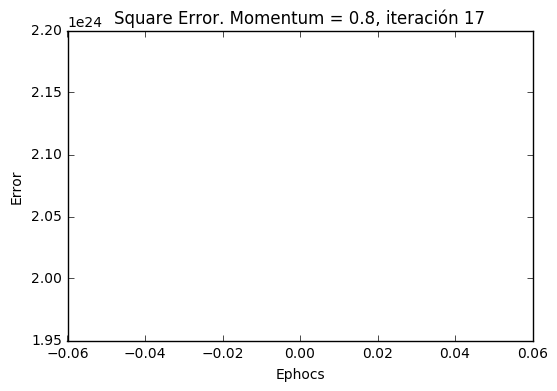

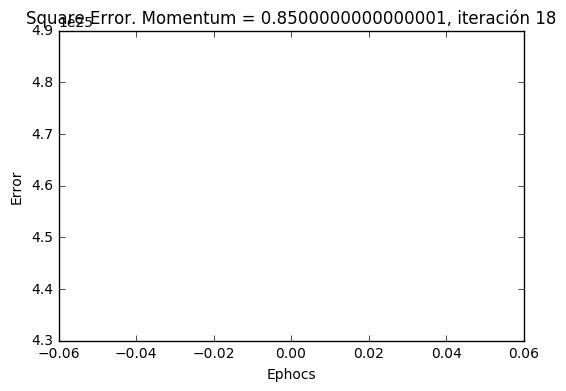

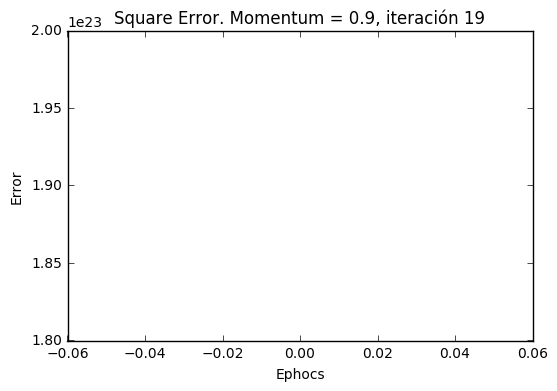

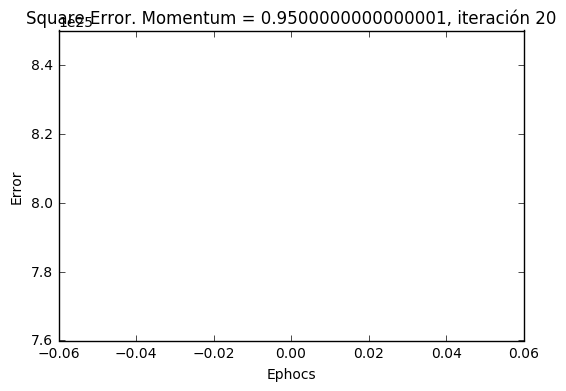

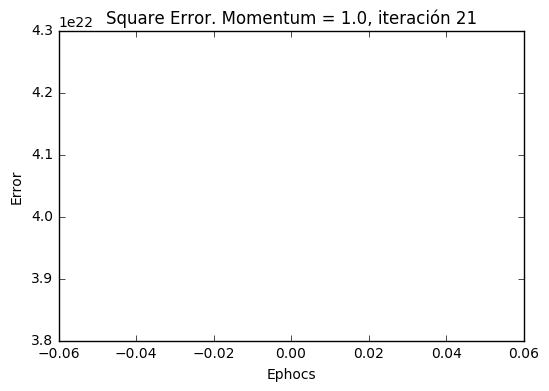

In [62]:
i = 1
for mom in momentum:
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=0.2,momentum=mom)
    model.compile(optimizer=sgd,loss='mean_squared_error')

    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # Graficamos
    plt.plot(hist.history['loss'])
    plt.title("Square Error. Momentum = {0}, iteración {1}".format(mom, i))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()
    i += 1

Como se puede ver en los gráficos, ninguno de los momentum utilizados permitió ayudar al método a converger por lo que no hubo diferencia en variar el momentum.

### j)

In [63]:
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))

Primero analizamos como influye el tamaño del *batch* en el modelo con función sigmoidal.

/Users/asanhuez/.miniconda2/envs/python3/lib/python3.5/site-packages/keras/engine/training.py:810: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  batch_ids = index_array[batch_start:batch_end]
/Users/asanhuez/.miniconda2/envs/python3/lib/python3.5/site-packages/keras/engine/training.py:917: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  batch_ids = index_array[batch_start:batch_end]


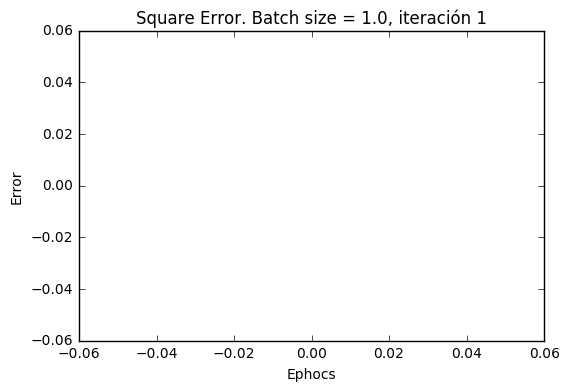

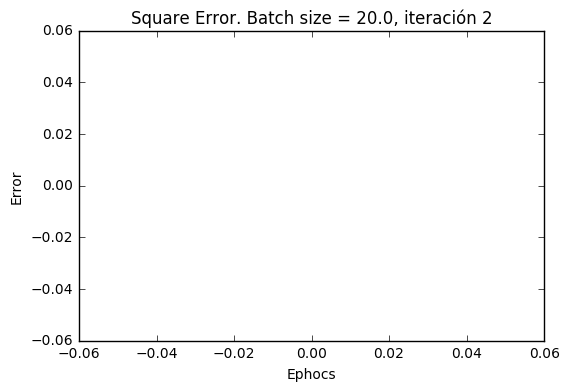

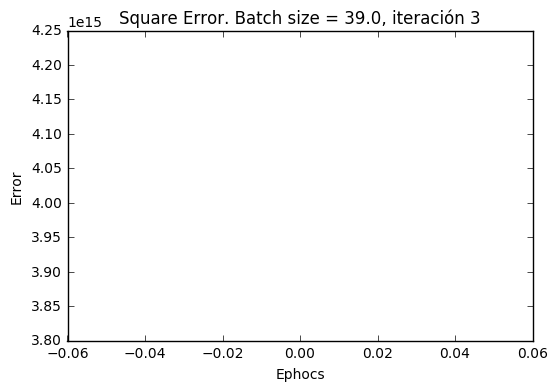

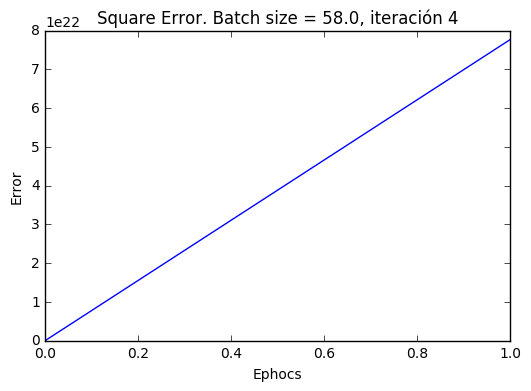

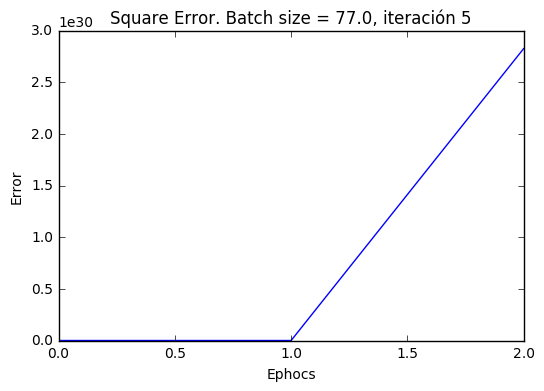

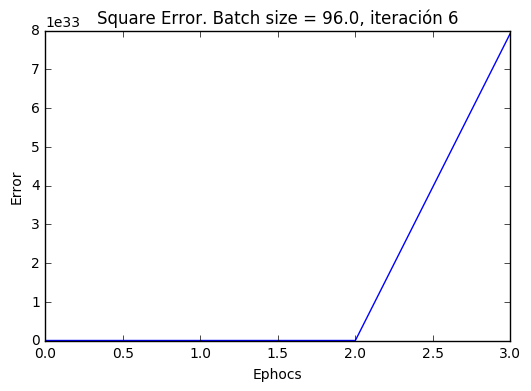

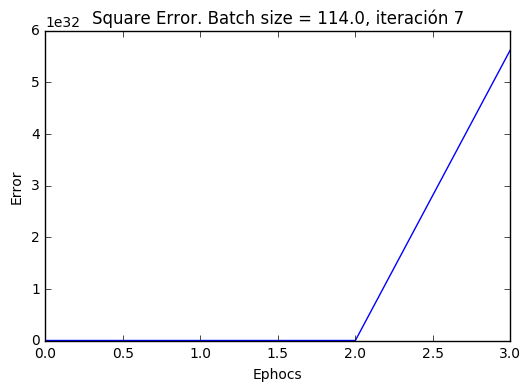

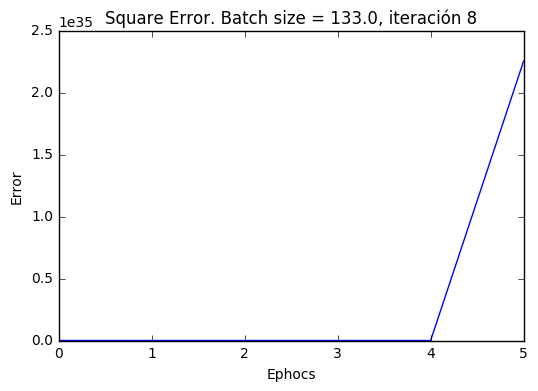

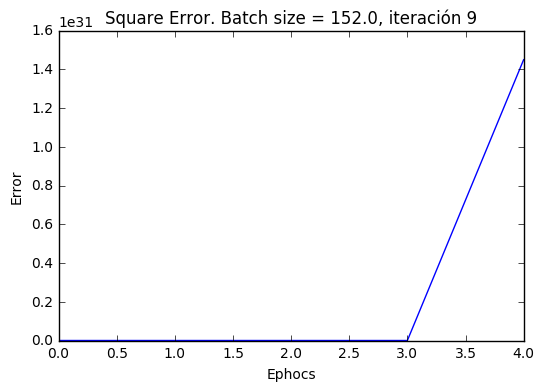

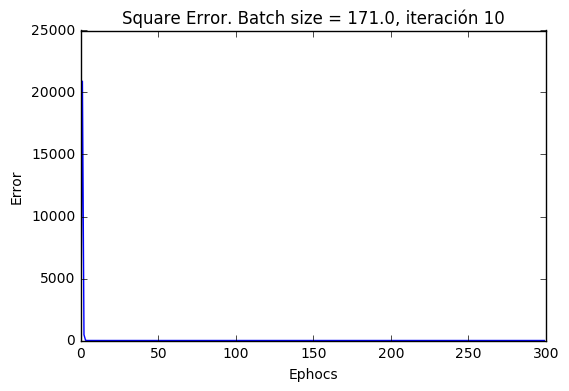

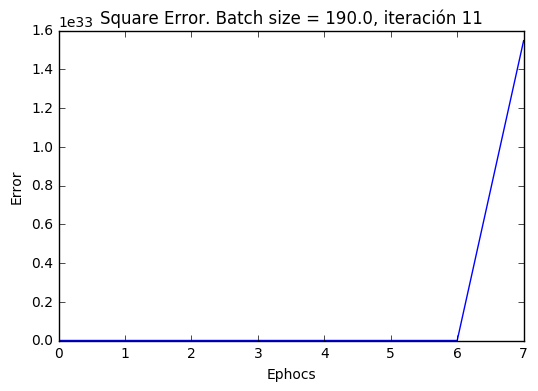

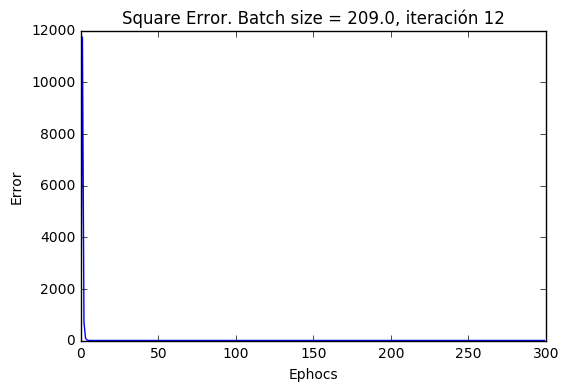

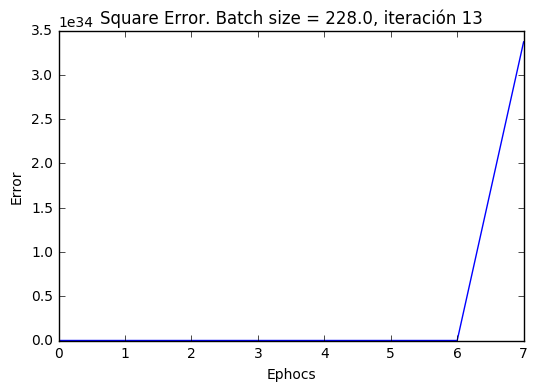

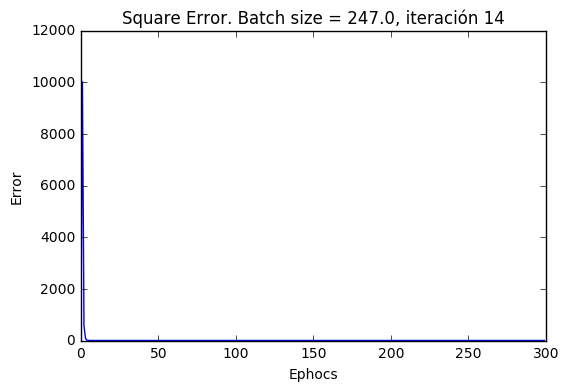

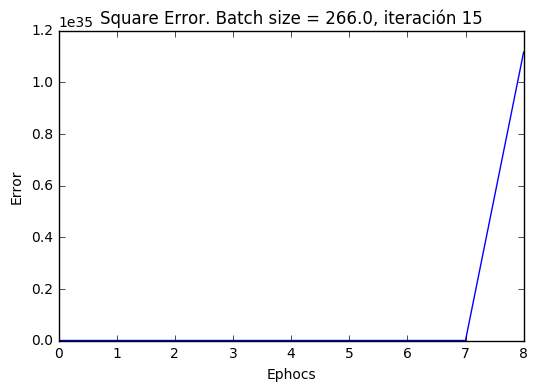

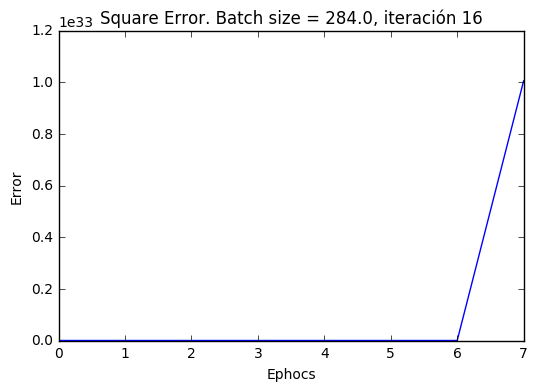

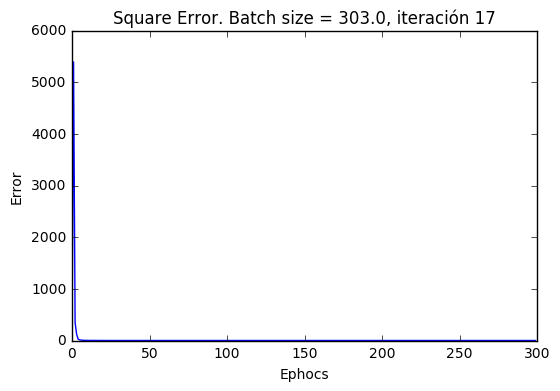

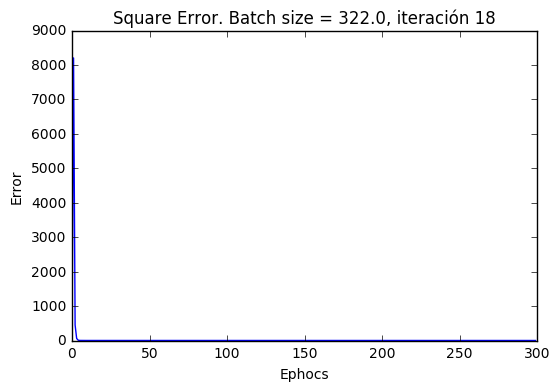

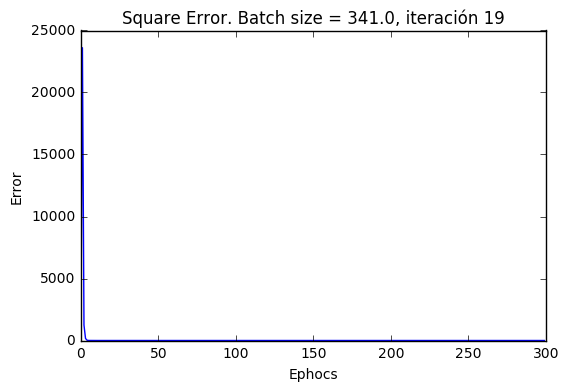

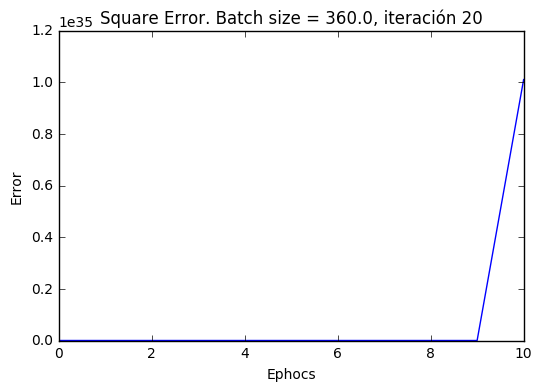

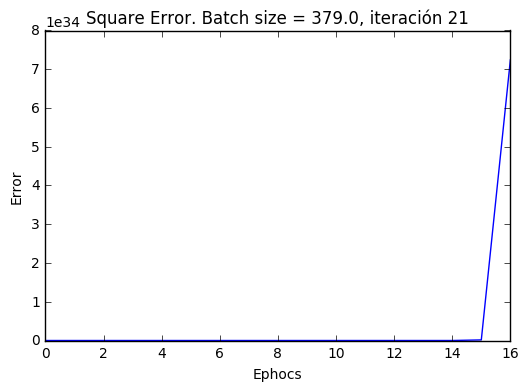

In [13]:
i = 1
for b in batch_sizes:
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=0.2)
    model.compile(optimizer=sgd,loss='mean_squared_error')

    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=0, batch_size=b, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # Graficamos
    plt.plot(hist.history['loss'])
    plt.title("Square Error. Batch size = {0}, iteración {1}".format(b, i))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()
    i += 1

Los gráficos muestran que para ciertos valores de *batch_size* se consigue la convergencia del método con errores considerables. Para el resto de los valores no hay convergencia (los puntos que logran obtener un gráfico obtiene valores del order de magnitud 1e35 por lo que el método diverge).

Ahora, utilizaremos la función Relu con los distintos valores para el tamaño del batch.

/Users/asanhuez/.miniconda2/envs/python3/lib/python3.5/site-packages/keras/engine/training.py:810: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  batch_ids = index_array[batch_start:batch_end]
/Users/asanhuez/.miniconda2/envs/python3/lib/python3.5/site-packages/keras/engine/training.py:917: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  batch_ids = index_array[batch_start:batch_end]


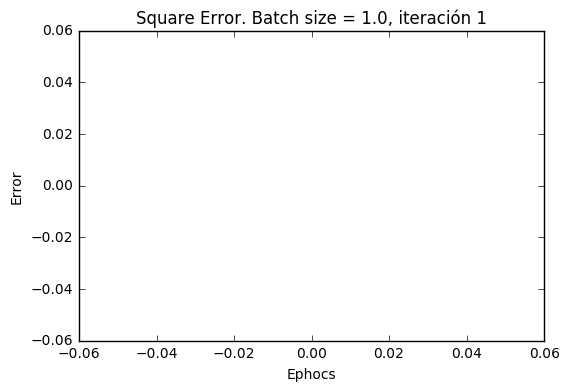

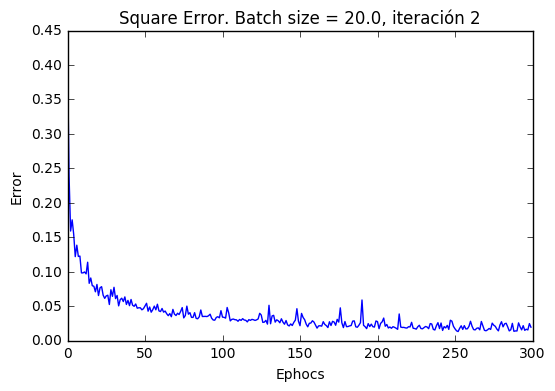

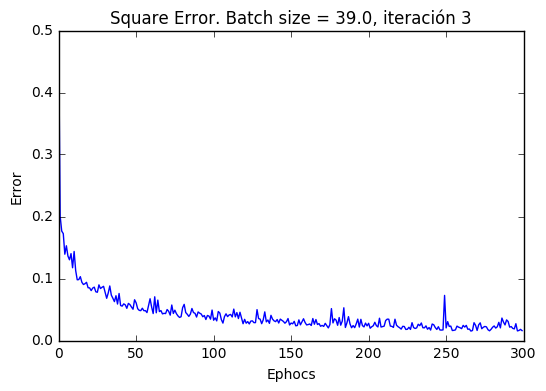

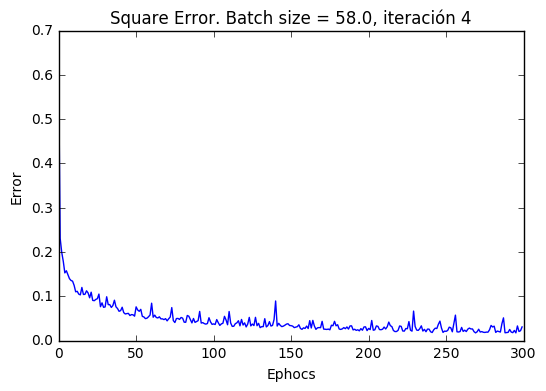

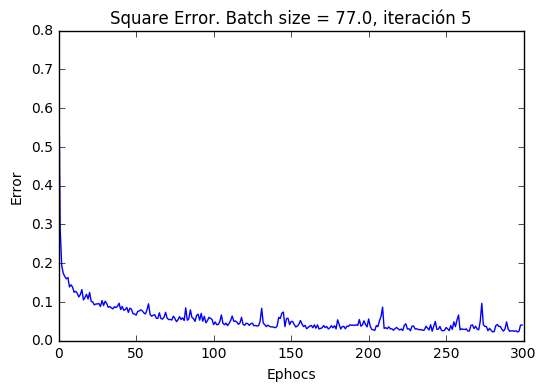

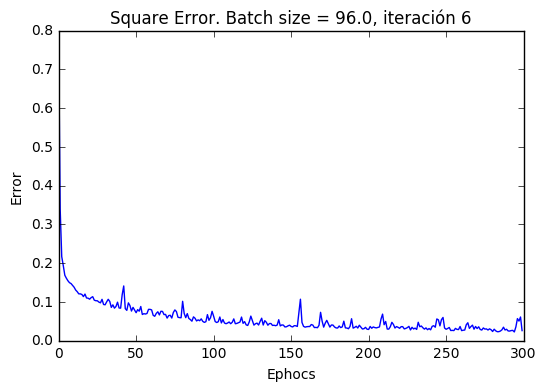

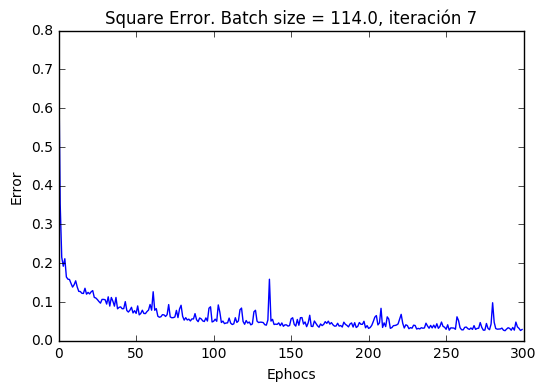

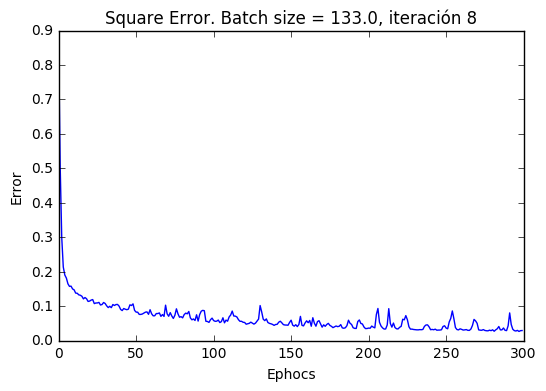

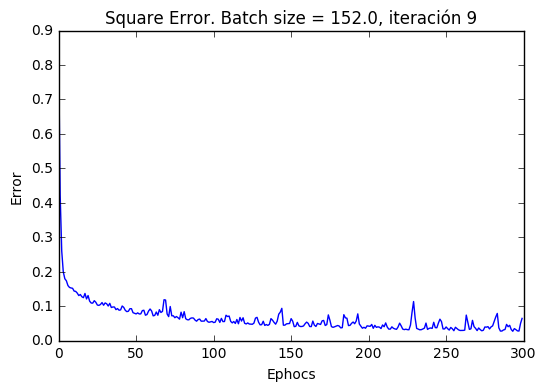

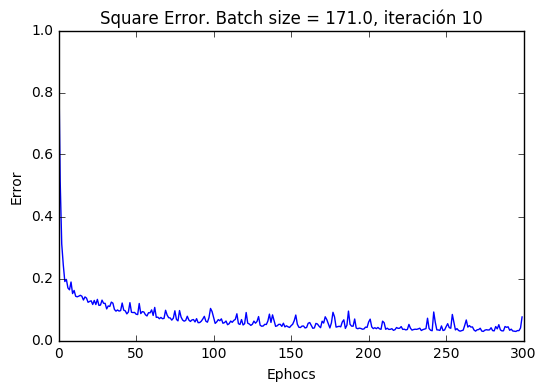

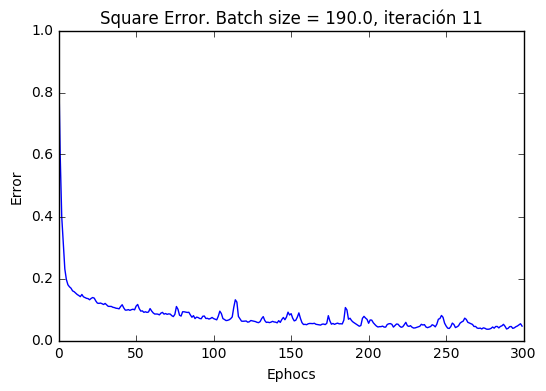

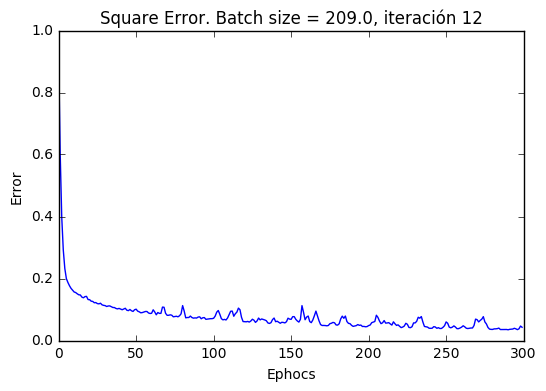

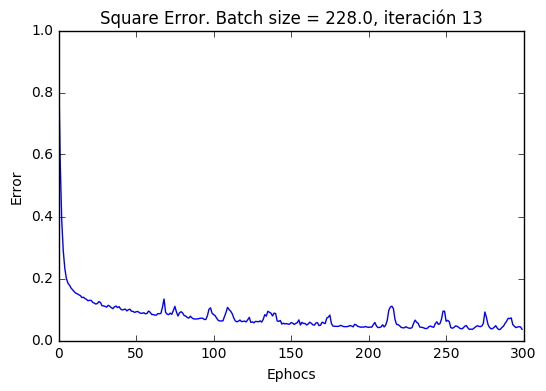

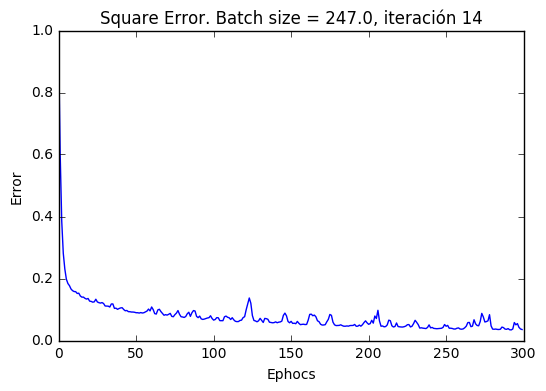

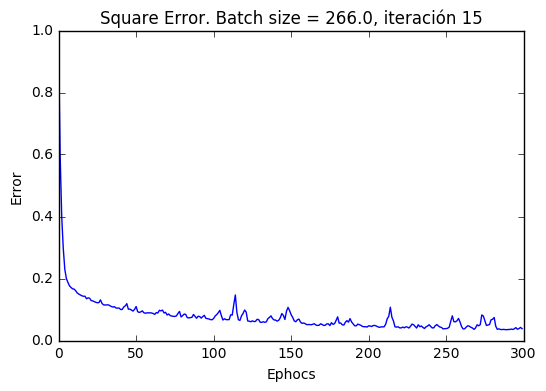

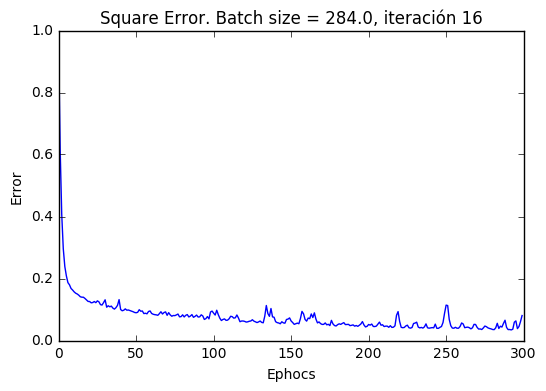

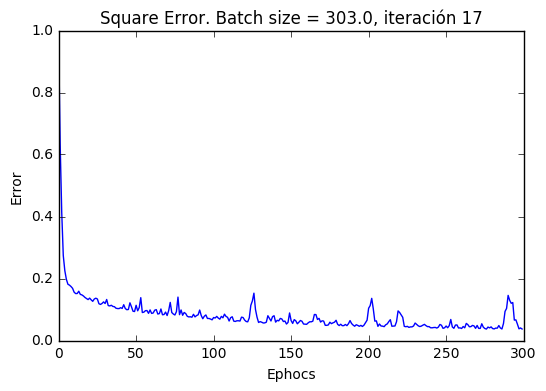

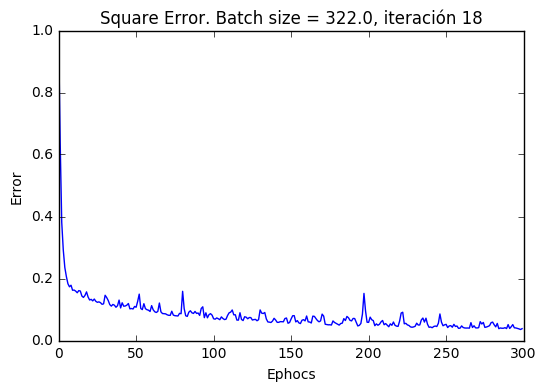

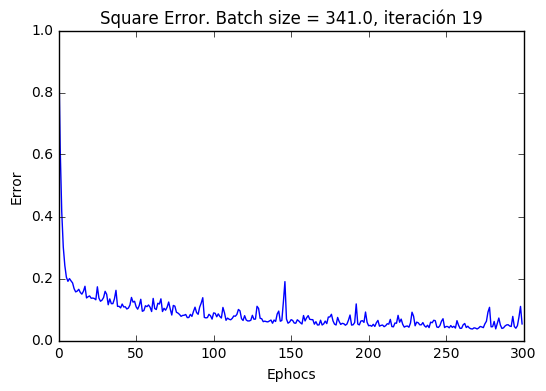

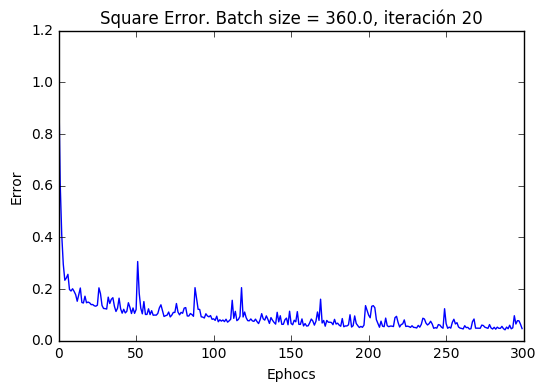

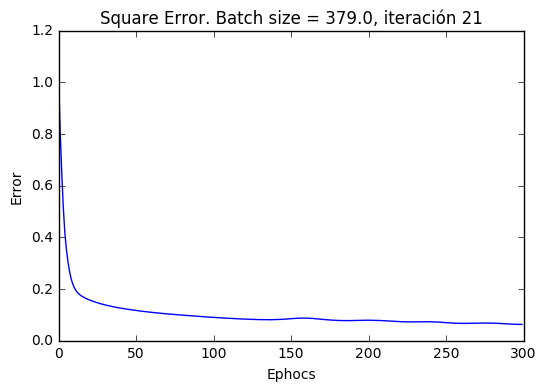

In [14]:
i = 1
for b in batch_sizes:
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=0.2)
    model.compile(optimizer=sgd,loss='mean_squared_error')

    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=0, batch_size=b, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # Graficamos
    plt.plot(hist.history['loss'])
    plt.title("Square Error. Batch size = {0}, iteración {1}".format(b, i))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()
    i += 1

El método se comportó bien para todos los tamaños de batch (con excepción de batch de tamaño uno). La forma de la curva fue similar para todos los otros casos.